In [1]:
import torch
print(torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

x = torch.ones((3, 3), device=device)
print(x.device)

True
mps:0


[Adam]  Epoch     0 | lr=1.00e-03 | Total:1.632e+03 | PDE:5.634e+00 | BC:3.253e+01
[Adam]  Epoch   500 | lr=9.94e-04 | Total:1.066e-01 | PDE:1.724e-02 | BC:1.787e-03
[Adam]  Epoch  1000 | lr=9.76e-04 | Total:7.119e-02 | PDE:7.502e-03 | BC:1.274e-03
[Adam]  Epoch  1500 | lr=9.46e-04 | Total:5.167e-02 | PDE:3.990e-03 | BC:9.536e-04
[Adam]  Epoch  2000 | lr=9.05e-04 | Total:3.772e-02 | PDE:2.517e-03 | BC:7.040e-04
[Adam]  Epoch  2500 | lr=8.55e-04 | Total:2.732e-02 | PDE:1.906e-03 | BC:5.083e-04
[Adam]  Epoch  3000 | lr=7.96e-04 | Total:1.905e-02 | PDE:1.316e-03 | BC:3.546e-04
[Adam]  Epoch  3500 | lr=7.30e-04 | Total:1.267e-02 | PDE:9.588e-04 | BC:2.341e-04
[Adam]  Epoch  4000 | lr=6.58e-04 | Total:7.901e-03 | PDE:7.301e-04 | BC:1.434e-04
[Adam]  Epoch  4500 | lr=5.82e-04 | Total:4.639e-03 | PDE:6.036e-04 | BC:8.071e-05
[Adam]  Epoch  5000 | lr=5.05e-04 | Total:2.567e-03 | PDE:5.062e-04 | BC:4.122e-05
[Adam]  Epoch  5500 | lr=4.27e-04 | Total:1.668e-02 | PDE:4.490e-04 | BC:3.247e-04
[Ada

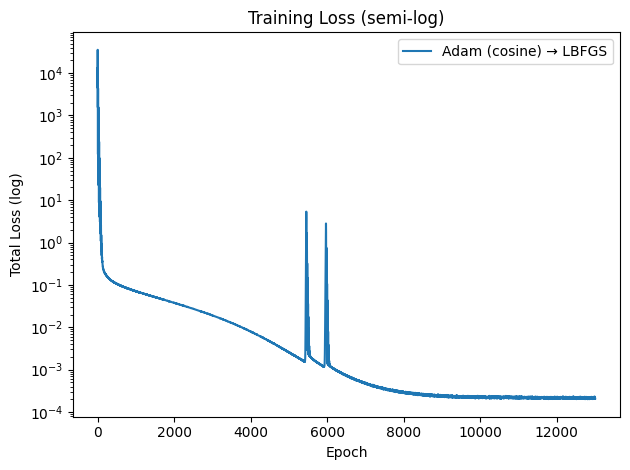

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# -------------------------
# Physical constants (unchanged)
# -------------------------
L, W = 1.0, 0.5
lambda_  = 5.64e9
mu_T = 2.46e9
theta_deg = 30
mu_L = 5.66e9
alpha = 1.26e9
beta = 227.29e9
h = 1.0
sf = 1e9

# -------------------------
# Model (unchanged)
# -------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))


theta_rad = np.deg2rad(theta_deg)
c = torch.tensor(np.cos(theta_rad), dtype=torch.float32)
s = torch.tensor(np.sin(theta_rad), dtype=torch.float32)

def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    Exx = u_x_true; Eyy = v_y_true; Exy = 0.5*(u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

def stress_tensor(Exx, Eyy, Exy):
    trE = Exx + Eyy
    Ea_x = Exx * c + Exy * s
    Ea_y = Exy * c + Eyy * s
    aEa  = Exx*(c*c) + 2.0*Exy*(c*s) + Eyy*(s*s)

    t1_xx = trE * (lambda_ + alpha*(c*c))
    t1_xy = trE * (alpha * c * s)
    t1_yy = trE * (lambda_ + alpha*(s*s))

    t2_xx = 2.0 * mu_T * Exx
    t2_xy = 2.0 * mu_T * Exy
    t2_yy = 2.0 * mu_T * Eyy

    t3_xx = aEa * (alpha + beta*(c*c))
    t3_xy = aEa * (beta * c * s)
    t3_yy = aEa * (alpha + beta*(s*s))

    A_xx = 2.0 * c * Ea_x
    A_xy = c * Ea_y + Ea_x * s
    A_yy = 2.0 * s * Ea_y
    K = 2.0 * (mu_L - mu_T)
    t4_xx = K * A_xx
    t4_xy = K * A_xy
    t4_yy = K * A_yy

    sig_xx = t1_xx + t2_xx + t3_xx + t4_xx
    sig_xy = t1_xy + t2_xy + t3_xy + t4_xy
    sig_yy = t1_yy + t2_yy + t3_yy + t4_yy

    Sxx = h * sig_xx / sf
    Sxy = h * sig_xy / sf
    Syy = h * sig_yy / sf
    return Sxx, Syy, Sxy

def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:, i:i+1] for i in range(6))
    u_x_true, u_y_true, v_x_true, v_y_true, _, _, _ = strain_tensor(u_net, v_net, x, y)

    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    Sxx_x = torch.autograd.grad(Sxx, x, torch.ones_like(Sxx), retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, torch.ones_like(Syy), retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad

def boundary_condition_loss(model, L, W):
    y_A = torch.linspace(-W/2, W/2, 500).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)

    x_D = L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A) 
    u_D, v_D = out_D[:,2:3], out_D[:,3:4]   # gradients on D (original intent)
    loss_D = torch.mean((u_D - 0.02*L)**2 + v_D**2)

    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

def train_adam_with_scheduler(model, n_epochs, n_points, L, W, lr=1e-3, eta_min=1e-5):
    """Adam with cosine LR; returns loss history."""
    w_pde, w_bc = 1.0, 50.0
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs, eta_min=eta_min)
    history = []
    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W - W/2
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        history.append(loss.item())
        if ep % 500 == 0:
            print(f"[Adam]  Epoch {ep:5d} | lr={sched.get_last_lr()[0]:.2e} | Total:{loss.item():.3e} | PDE:{lp.item():.3e} | BC:{lb.item():.3e}")
    return history

def train_lbfgs_finetune(model, n_epochs, n_points, L, W, lr=1.0):
    """
    Lightweight LBFGS fine-tune: run n_epochs single-step LBFGS iterations so
    we can report per-epoch history (minimal code change).
    """
    w_pde, w_bc = 1.0, 50.0
    history = []
    for ep in range(n_epochs):
        opt = torch.optim.LBFGS(
            model.parameters(), lr=lr, max_iter=1,
            line_search_fn="strong_wolfe", history_size=100,
            tolerance_grad=1e-10, tolerance_change=1e-12
        )
        def closure():
            opt.zero_grad()
            x = torch.rand(n_points,1)*L - L/2
            y = torch.rand(n_points,1)*W - W/2
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model, L, W)
            loss = w_pde*lp + w_bc*lb
            loss.backward()
            return loss
        loss = opt.step(closure)
        history.append(loss.item())
        if ep % 200 == 0:
            print(f"[LBFGS] Epoch {ep:5d} | loss={loss.item():.3e}")
    return history

model = PINN()

ADAM_EPOCHS  = 10000   # tweak split if you want
LBFGS_EPOCHS = 3000
n_epochs = ADAM_EPOCHS + LBFGS_EPOCHS   # total stays 13k
n_points = 1000

adam_hist  = train_adam_with_scheduler(model, ADAM_EPOCHS,  n_points, L, W, lr=1e-3, eta_min=1e-5)
lbfgs_hist = train_lbfgs_finetune(model, LBFGS_EPOCHS, n_points, L, W, lr=1.0)

loss_history = adam_hist + lbfgs_hist  # combined


torch.save(model.state_dict(), "pinn_fiber_elasticity_new.pth")
print("✅ Model weights saved to pinn_fiber_elasticity_new.pth")

plt.figure()
iters = np.arange(1, len(loss_history)+1)
plt.semilogy(iters, loss_history, label="Adam (cosine) → LBFGS")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (log)"); plt.title("Training Loss (semi-log)")
plt.legend(); plt.tight_layout(); plt.show()


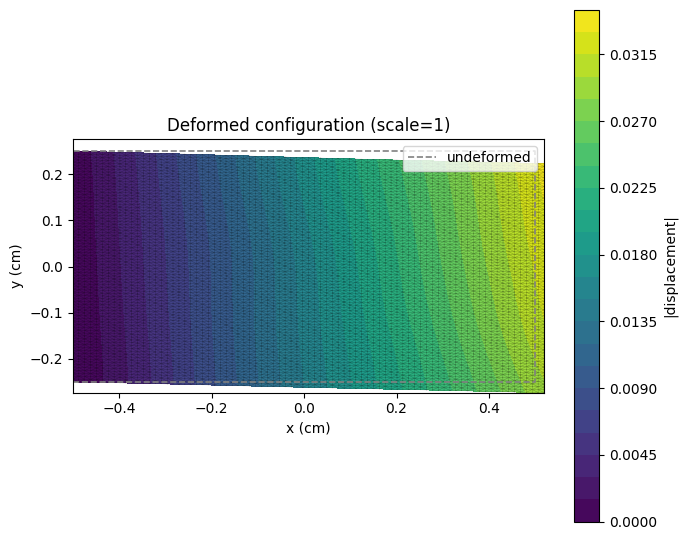

In [3]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

@torch.no_grad()
def plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0, cmap="viridis"):
    model.eval()
    device = next(model.parameters()).device

    # Build a uniform grid over the plate
    xs = torch.linspace(-L/2, L/2, n_per_side, device=device)
    ys = torch.linspace(-W/2, W/2, n_per_side, device=device)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    x = Xg.reshape(-1, 1)
    y = Yg.reshape(-1, 1)

    # Predict [u, v] with the PINN
    out = model(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Deformed coordinates (amplified by 'scale' for visibility)
    x_def = (x + scale * u).detach().cpu().numpy().ravel()
    y_def = (y + scale * v).detach().cpu().numpy().ravel()

    # Undeformed for reference
    x_und = x.detach().cpu().numpy().ravel()
    y_und = y.detach().cpu().numpy().ravel()

    # Triangulate the (regular) grid for a nicer surface plot
    tri = mtri.Triangulation(x_und, y_und)

    # Displacement magnitude for coloring
    disp_mag = torch.sqrt(u**2 + v**2).detach().cpu().numpy().ravel()

    # Plot
    plt.figure(figsize=(7, 5.5))
    tpc = plt.tricontourf(x_def, y_def, tri.triangles, disp_mag, levels=30, cmap=cmap)
    plt.colorbar(tpc, label="|displacement|")
    # draw deformed mesh lines
    plt.triplot(x_def, y_def, tri.triangles, lw=0.3, color="k", alpha=0.35)

    # outline of undeformed boundary for reference
    plt.plot([ -L/2,  L/2,  L/2, -L/2, -L/2 ],
             [ -W/2, -W/2,  W/2,  W/2, -W/2 ], ls="--", lw=1.2, color="gray", label="undeformed")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (cm)"); plt.ylabel("y (cm)")
    plt.title(f"Deformed configuration (scale={scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ---- Call it (pick a scale so it’s visible; try 50–200 if displacements are tiny) ----
plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0)


[Adam]  Epoch     0 | lr=1.00e-03 | Total:1.280e+04 | PDE:5.775e+00 | BC:2.559e+02
[Adam]  Epoch   500 | lr=9.94e-04 | Total:3.961e-02 | PDE:1.014e-02 | BC:5.895e-04
[Adam]  Epoch  1000 | lr=9.75e-04 | Total:2.210e-02 | PDE:3.811e-03 | BC:3.658e-04
[Adam]  Epoch  1500 | lr=9.45e-04 | Total:1.372e-02 | PDE:2.665e-03 | BC:2.211e-04
[Adam]  Epoch  2000 | lr=9.04e-04 | Total:8.236e-03 | PDE:2.179e-03 | BC:1.211e-04
[Adam]  Epoch  2500 | lr=8.53e-04 | Total:4.532e-03 | PDE:1.585e-03 | BC:5.894e-05
[Adam]  Epoch  3000 | lr=7.94e-04 | Total:2.456e-03 | PDE:1.170e-03 | BC:2.573e-05
[Adam]  Epoch  3500 | lr=7.27e-04 | Total:1.487e-03 | PDE:9.367e-04 | BC:1.100e-05
[Adam]  Epoch  4000 | lr=6.54e-04 | Total:1.234e+00 | PDE:7.570e-04 | BC:2.467e-02
[Adam]  Epoch  4500 | lr=5.78e-04 | Total:1.207e-03 | PDE:6.806e-04 | BC:1.052e-05
[Adam]  Epoch  5000 | lr=5.00e-04 | Total:9.860e-04 | PDE:5.796e-04 | BC:8.128e-06
[Adam]  Epoch  5500 | lr=4.22e-04 | Total:8.332e-04 | PDE:5.657e-04 | BC:5.350e-06
[Ada

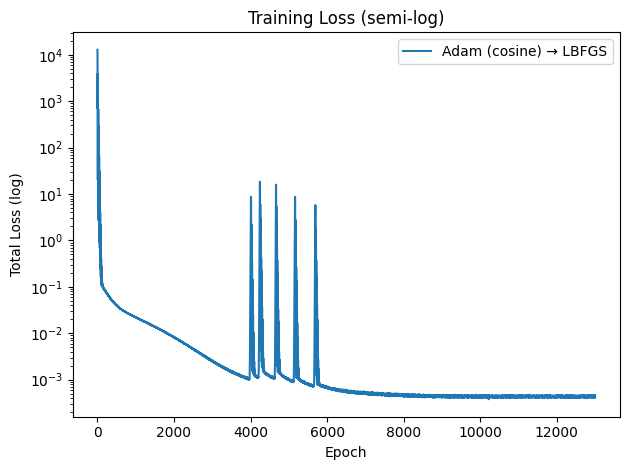

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# -------------------------
# Physical constants (unchanged)
# -------------------------
L, W = 1.0, 0.5
lambda_  = 5.64e9
mu_T = 2.46e9
theta_deg = 30
mu_L = 5.66e9
alpha = 1.26e9
beta = 227.29e9
h = 1.0
sf = 1e9

# -------------------------
# Model (unchanged)
# -------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))


theta_rad = np.deg2rad(theta_deg)
c = torch.tensor(np.cos(theta_rad), dtype=torch.float32)
s = torch.tensor(np.sin(theta_rad), dtype=torch.float32)

def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    Exx = u_x_true; Eyy = v_y_true; Exy = 0.5*(u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

def stress_tensor(Exx, Eyy, Exy):
    trE = Exx + Eyy
    Ea_x = Exx * c + Exy * s
    Ea_y = Exy * c + Eyy * s
    aEa  = Exx*(c*c) + 2.0*Exy*(c*s) + Eyy*(s*s)

    t1_xx = trE * (lambda_ + alpha*(c*c))
    t1_xy = trE * (alpha * c * s)
    t1_yy = trE * (lambda_ + alpha*(s*s))

    t2_xx = 2.0 * mu_T * Exx
    t2_xy = 2.0 * mu_T * Exy
    t2_yy = 2.0 * mu_T * Eyy

    t3_xx = aEa * (alpha + beta*(c*c))
    t3_xy = aEa * (beta * c * s)
    t3_yy = aEa * (alpha + beta*(s*s))

    A_xx = 2.0 * c * Ea_x
    A_xy = c * Ea_y + Ea_x * s
    A_yy = 2.0 * s * Ea_y
    K = 2.0 * (mu_L - mu_T)
    t4_xx = K * A_xx
    t4_xy = K * A_xy
    t4_yy = K * A_yy

    sig_xx = t1_xx + t2_xx + t3_xx + t4_xx
    sig_xy = t1_xy + t2_xy + t3_xy + t4_xy
    sig_yy = t1_yy + t2_yy + t3_yy + t4_yy

    Sxx = h * sig_xx / sf
    Sxy = h * sig_xy / sf
    Syy = h * sig_yy / sf
    return Sxx, Syy, Sxy

def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:, i:i+1] for i in range(6))
    u_x_true, u_y_true, v_x_true, v_y_true, _, _, _ = strain_tensor(u_net, v_net, x, y)

    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    Sxx_x = torch.autograd.grad(Sxx, x, torch.ones_like(Sxx), retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, torch.ones_like(Syy), retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad

def boundary_condition_loss(model, L, W):
    y_A = torch.linspace(-W/2, W/2, 500).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)

    EPS0 = 0.02
    LOAD_SIGN = -1.0

    x_D =  L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A)

    u_x_D = out_D[:,2:3]   # ε_xx
    loss_D_strain = torch.mean((u_x_D - LOAD_SIGN*EPS0)**2)
    
    # optional: shear-free edge to avoid artificial vertical drift
    Exx_D, Eyy_D = out_D[:,2:3], out_D[:,5:6]
    Exy_D = 0.5*(out_D[:,3:4] + out_D[:,4:5])
    _, _, Sxy_D = stress_tensor(Exx_D, Eyy_D, Exy_D)
    loss_D = loss_D_strain + 0.1*torch.mean(Sxy_D**2)    

    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

def train_adam_with_scheduler(model, n_epochs, n_points, L, W, lr=1e-3, eta_min=1e-5):
    """Adam with cosine LR; returns loss history."""
    w_pde, w_bc = 1.0, 50.0
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs, eta_min=eta_min)
    history = []
    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W - W/2
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        history.append(loss.item())
        if ep % 500 == 0:
            print(f"[Adam]  Epoch {ep:5d} | lr={sched.get_last_lr()[0]:.2e} | Total:{loss.item():.3e} | PDE:{lp.item():.3e} | BC:{lb.item():.3e}")
    return history

def train_lbfgs_finetune(model, n_epochs, n_points, L, W, lr=1.0):
    """
    Lightweight LBFGS fine-tune: run n_epochs single-step LBFGS iterations so
    we can report per-epoch history (minimal code change).
    """
    w_pde, w_bc = 1.0, 50.0
    history = []
    for ep in range(n_epochs):
        opt = torch.optim.LBFGS(
            model.parameters(), lr=lr, max_iter=1,
            line_search_fn="strong_wolfe", history_size=100,
            tolerance_grad=1e-10, tolerance_change=1e-12
        )
        def closure():
            opt.zero_grad()
            x = torch.rand(n_points,1)*L - L/2
            y = torch.rand(n_points,1)*W - W/2
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model, L, W)
            loss = w_pde*lp + w_bc*lb
            loss.backward()
            return loss
        loss = opt.step(closure)
        history.append(loss.item())
        if ep % 200 == 0:
            print(f"[LBFGS] Epoch {ep:5d} | loss={loss.item():.3e}")
    return history

model_compression = PINN()

ADAM_EPOCHS  = 10000   # tweak split if you want
LBFGS_EPOCHS = 3000
n_epochs = ADAM_EPOCHS + LBFGS_EPOCHS   # total stays 13k
n_points = 1000

adam_hist  = train_adam_with_scheduler(model_compression, ADAM_EPOCHS,  n_points, L, W, lr=1e-3, eta_min=1e-7)
lbfgs_hist = train_lbfgs_finetune(model_compression, LBFGS_EPOCHS, n_points, L, W, lr=1.0)

loss_history = adam_hist + lbfgs_hist  # combined


torch.save(model_compression.state_dict(), "pinn_fiber_elasticity_compression.pth")
print("✅ Model weights saved to pinn_fiber_elasticity_compression.pth")

plt.figure()
iters = np.arange(1, len(loss_history)+1)
plt.semilogy(iters, loss_history, label="Adam (cosine) → LBFGS")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (log)"); plt.title("Training Loss (semi-log)")
plt.legend(); plt.tight_layout(); plt.show()


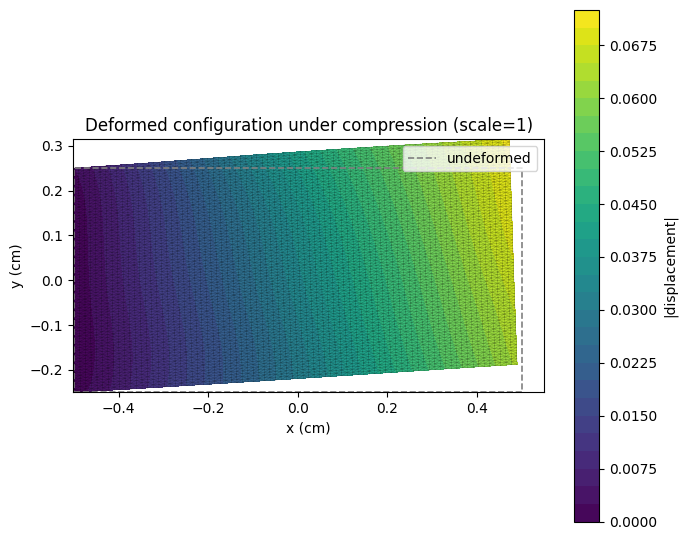

In [5]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

@torch.no_grad()
def plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0, cmap="viridis"):
    model_compression.eval()
    device = next(model_compression.parameters()).device

    # Build a uniform grid over the plate
    xs = torch.linspace(-L/2, L/2, n_per_side, device=device)
    ys = torch.linspace(-W/2, W/2, n_per_side, device=device)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    x = Xg.reshape(-1, 1)
    y = Yg.reshape(-1, 1)

    # Predict [u, v] with the PINN
    out = model_compression(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Deformed coordinates (amplified by 'scale' for visibility)
    x_def = (x + scale * u).detach().cpu().numpy().ravel()
    y_def = (y + scale * v).detach().cpu().numpy().ravel()

    # Undeformed for reference
    x_und = x.detach().cpu().numpy().ravel()
    y_und = y.detach().cpu().numpy().ravel()

    # Triangulate the (regular) grid for a nicer surface plot
    tri = mtri.Triangulation(x_und, y_und)

    # Displacement magnitude for coloring
    disp_mag = torch.sqrt(u**2 + v**2).detach().cpu().numpy().ravel()

    # Plot
    plt.figure(figsize=(7, 5.5))
    tpc = plt.tricontourf(x_def, y_def, tri.triangles, disp_mag, levels=30, cmap=cmap)
    plt.colorbar(tpc, label="|displacement|")
    # draw deformed mesh lines
    plt.triplot(x_def, y_def, tri.triangles, lw=0.3, color="k", alpha=0.35)

    # outline of undeformed boundary for reference
    plt.plot([ -L/2,  L/2,  L/2, -L/2, -L/2 ],
             [ -W/2, -W/2,  W/2,  W/2, -W/2 ], ls="--", lw=1.2, color="gray", label="undeformed")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (cm)"); plt.ylabel("y (cm)")
    plt.title(f"Deformed configuration under compression (scale={scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ---- Call it (pick a scale so it’s visible; try 50–200 if displacements are tiny) ----
plot_deformed_configuration(model_compression, L, W, n_per_side=81, scale=1.0)
